In [1]:
using DrWatson
@quickactivate projectdir()

In [2]:
include(srcdir("rdpg.jl"))
import Main.rdpg
using StatsBase, Clustering, Pipe, Graphs, GraphIO, Suppressor, LightGraphs, DelimitedFiles
using Plots, Ripserer, PersistenceDiagrams, PersistenceDiagramsBase, ProgressMeter
gr()

Plots.GRBackend()

In [3]:
function diagram(X)
    points = tuple.(eachcol(X)...)
    dgm = ripserer(points, dim_max=1)
    return dgm
end

function bottleneck_distances(X, Y, dim_max)
    DX = diagram(X)
    DY = diagram(Y)
    return [Bottleneck()(DX, DY)]
end

function simulate_one(A, d, epsilon)
    X, _, _ = rdpg.spectralEmbed(A, d=d + 1, scale=false)
    A_private = rdpg.edgeFlip(A, ϵ=epsilon) .- rdpg.privacy(ϵ=epsilon)
    X_private, _, _ = rdpg.spectralEmbed(A_private, d=d + 1, scale=false)
    X_private = X_private ./ (1 - 2 * rdpg.privacy(ϵ=epsilon))
    return bottleneck_distances(X, X_private, d)
end

simulate_one (generic function with 1 method)

In [4]:
path_to_graph = datadir("email-Eu-core.txt")
path_to_labels = datadir("email-Eu-core-department-labels.txt")

G = Graphs.loadgraph(path_to_graph, "graph_key", EdgeListFormat())
A = Graphs.LinAlg.adjacency_matrix(G) |> LightGraphs.LinAlg.symmetrize

labels = convert.(Int, readdlm(path_to_labels))[:, 2];

In [5]:
subsample = false
if (subsample)
    N = size(A, 1)
    idx = sample(1:N, n, replace=false)
    A = A[idx, idx]
end

In [6]:
labels |> unique

42-element Vector{Int64}:
  1
 21
 25
 14
  9
 26
  4
 17
 34
 11
  ⋮
 24
 32
 31
 39
 12
 30
 41
 18
 33

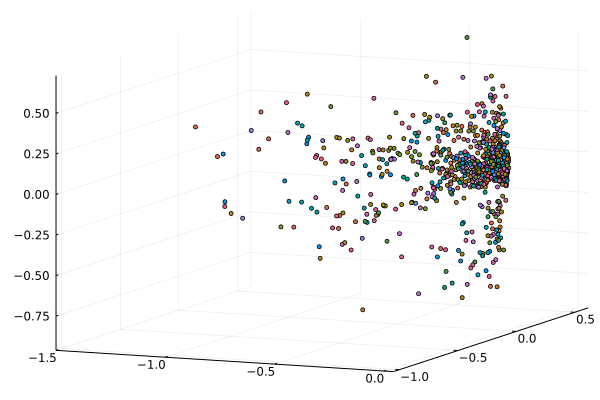

In [7]:
d = 20
Xnh, _ = rdpg.spectralEmbed(A, d=d, scale=false)
plt1 = @pipe Xnh[:, 1:3] |> rdpg._Matrix_to_ArrayOfTuples |> scatter(_, markersize=3, groups=labels, legend=nothing)

In [8]:
k = 3
freqs = @pipe labels |> countmap |> collect |> sort(_, by=x -> x[2], rev=:true)
labs = [x[1] for x in freqs[1:k]]

filtered_labels = filter(x -> x in labs, labels)
filtered_ids = filter(i -> labels[i] in labs, 1:size(A, 1))
A = A[filtered_ids, filtered_ids];

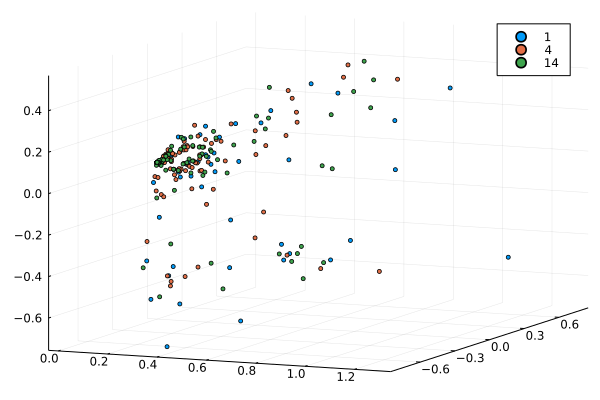

In [9]:
Xnh, _ = rdpg.spectralEmbed(A, d=d, scale=false)
plt1 = @pipe Xnh[:, 1:3] |> rdpg._Matrix_to_ArrayOfTuples |> scatter(_, markersize=3, groups=filtered_labels)

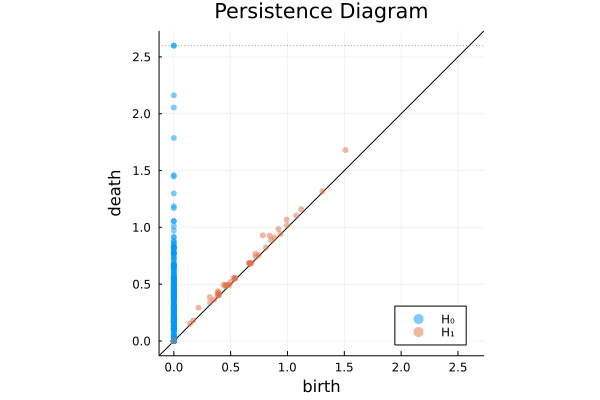

In [10]:
Dx = @pipe Xnh |>
            rdpg._Matrix_to_ArrayOfTuples |>
            ripserer(_, dim_max=1, reps=true, alg=:involuted)
@suppress plot(Dx) |> display

In [11]:
function stdscore(w)
    return [abs(x - mean(w)) / std(w) for x in w]
end

stdscore (generic function with 1 method)

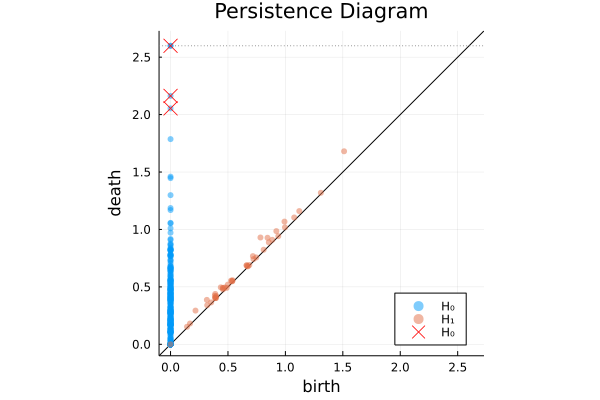

[263, 264, 265]


In [12]:
q = 4
order = 1 # order = dim + 1
u1 = Ripserer.persistence.(Dx[order][1:end-1])
index1 = findall(x -> x > q, stdscore(u1))
println(index1)
pltx = plot(
    plot(Dx), Dx[order][index1], lim=(-0.1, Inf),
    markercolor="red", markeralpha=1, markershape=:x, markersize=7
)

pltx |> display

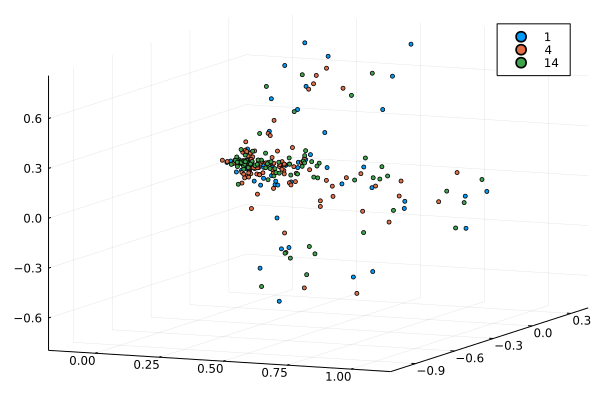

In [13]:
ϵ = 5.0
B = (rdpg.edgeFlip(A, ϵ=ϵ) .- rdpg.τ(ϵ)) ./ rdpg.σ(ϵ)^2
Ynh, _ = rdpg.spectralEmbed(B, d=d, scale=false)
plt2 = @pipe Ynh[:, 1:3] |> rdpg._Matrix_to_ArrayOfTuples |> scatter(_, markersize=3, groups=filtered_labels)

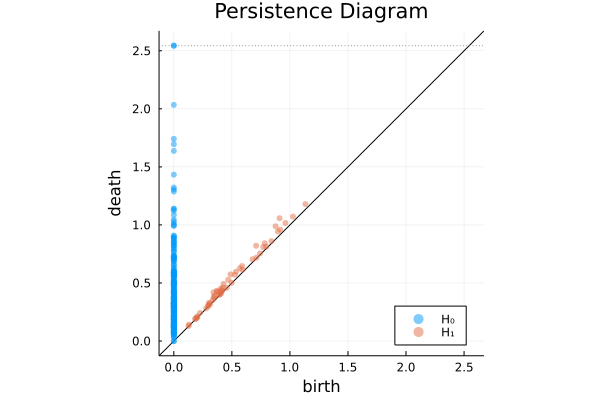

In [14]:
Dy = @pipe Ynh |>
            rdpg._Matrix_to_ArrayOfTuples |>
            ripserer(_, dim_max=1, reps=true)
plot(Dy)

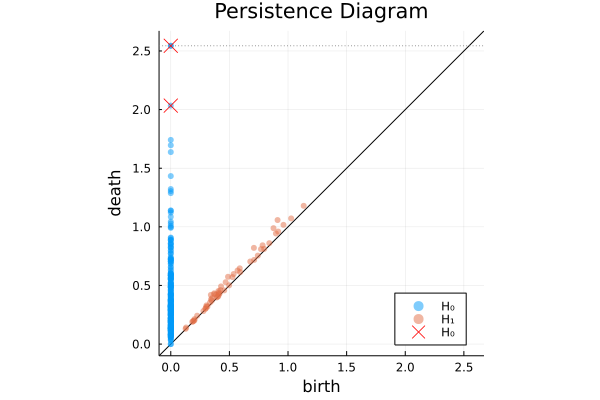

[264, 265]


In [15]:
q = 4
order = 1 # order = dim + 1
u2 = Ripserer.persistence.(Dy[order][1:end-1])
index2 = findall(x -> x > q, stdscore(u2))
println(index2)
plty = plot(
    plot(Dy), Dy[order][index2], lim=(-0.1, Inf),
    markercolor="red", markeralpha=1, markershape=:x, markersize=7
) 
plty |> display

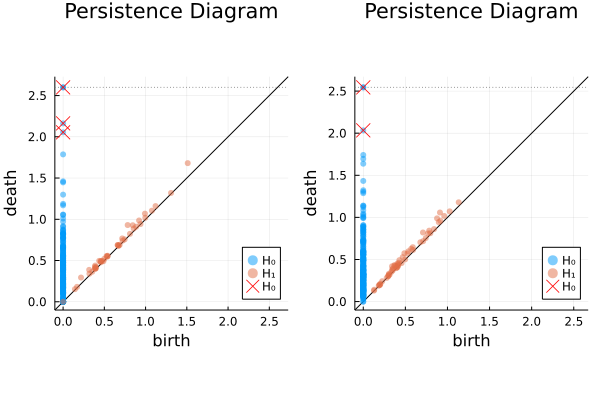

In [16]:
plot(pltx, plty)

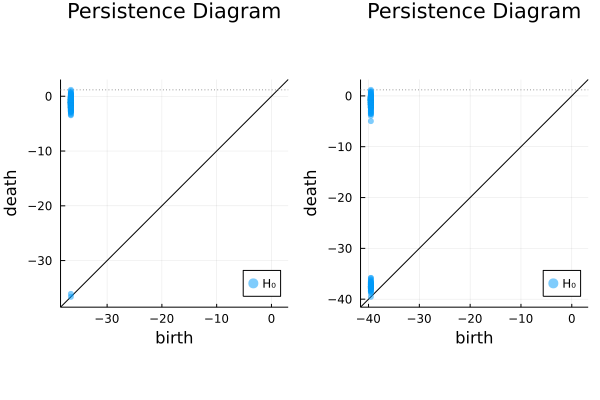

In [17]:
plot(
    [Dy[1]] |> rdpg.log_transform_diagram |> plot,
    [Dx[1]] |> rdpg.log_transform_diagram |> plot
)

In [18]:
repeats = 5
Eps = [0.05, 0.1, 0.2, 0.5, 0.8, 1:3...]
m = length(Eps)

results = zeros(repeats, m)

prog = Progress(convert(Int, m * repeats))

for i in 1:m
    for j in 1:repeats
        error = simulate_one(A, 10, Eps[i])
        results[j, i] = error[1]
        next!(prog)
    end
end

Progress:   5%|██                                       |  ETA: 0:01:10

Progress:  15%|██████▏                                  |  ETA: 0:00:30

Progress:  18%|███████▏                                 |  ETA: 0:00:26

Progress:  20%|████████▎                                |  ETA: 0:00:23

Progress:  22%|█████████▎                               |  ETA: 0:00:20

Progress:  25%|██████████▎                              |  ETA: 0:00:18

Progress:  28%|███████████▎                             |  ETA: 0:00:17

Progress:  30%|████████████▎                            |  ETA: 0:00:15

Progress:  32%|█████████████▍                           |  ETA: 0:00:14

Progress:  35%|██████████████▍                          |  ETA: 0:00:13

Progress:  38%|███████████████▍                         |  ETA: 0:00:12

Progress:  40%|████████████████▍                        |  ETA: 0:00:11

Progress:  42%|█████████████████▍                       |  ETA: 0:00:10

Progress:  45%|██████████████████▌                      |  ETA: 0:00:09

Progress:  48%|███████████████████▌                     |  ETA: 0:00:09

Progress:  50%|████████████████████▌                    |  ETA: 0:00:08

Progress:  52%|█████████████████████▌                   |  ETA: 0:00:08

Progress:  55%|██████████████████████▌                  |  ETA: 0:00:07

Progress:  58%|███████████████████████▋                 |  ETA: 0:00:06

Progress:  60%|████████████████████████▋                |  ETA: 0:00:06

Progress:  62%|█████████████████████████▋               |  ETA: 0:00:05

Progress:  65%|██████████████████████████▋              |  ETA: 0:00:05

Progress:  68%|███████████████████████████▋             |  ETA: 0:00:05

Progress:  70%|████████████████████████████▊            |  ETA: 0:00:04

Progress:  72%|█████████████████████████████▊           |  ETA: 0:00:04

Progress:  75%|██████████████████████████████▊          |  ETA: 0:00:03

Progress:  78%|███████████████████████████████▊         |  ETA: 0:00:03

Progress:  80%|████████████████████████████████▊        |  ETA: 0:00:03

Progress:  82%|█████████████████████████████████▉       |  ETA: 0:00:02

Progress:  85%|██████████████████████████████████▉      |  ETA: 0:00:02

Progress:  88%|███████████████████████████████████▉     |  ETA: 0:00:02

Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:01

Progress:  92%|█████████████████████████████████████▉   |  ETA: 0:00:01

Progress:  95%|███████████████████████████████████████  |  ETA: 0:00:01

Progress:  98%|████████████████████████████████████████ |  ETA: 0:00:00

Progress: 100%|█████████████████████████████████████████| Time: 0:00:11


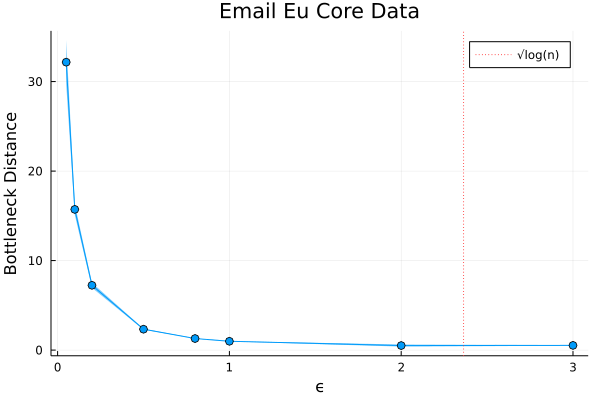

In [19]:
plt = plot(title="Email Eu Core Data", xlabel="ϵ", ylabel="Bottleneck Distance", ledend=:right)
plt = plot(plt, Eps, 
    mean(results, dims=1)',
    ribbon = std(results, dims=1)',
    marker=:o,
    label=nothing
)
vline!([sqrt(log(size(A,1)))], position=:bottomright, label="√log(n)", line=:dot, c=:firebrick1)